AutoRegressive Integrated Moving Average

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


●-Augmented Dickey-Fuller (ADF) test

In [32]:
file_path = "C:/Users/chimc/Desktop/Thomsun Infocare/capricorn UAT data/data2024.csv"
df = pd.read_csv(file_path,  encoding='ISO-8859-1', parse_dates=["invoicedate"], index_col="invoicedate")

In [55]:
# Ensure data is sorted by date
df = df.sort_index()

# Aggregate sales by day
sales_data_daily = df["salesamount"].resample("D").sum()

In [57]:
from statsmodels.tsa.stattools import adfuller

In [58]:
# Perform ADF test on daily sales
adf_result = adfuller(sales_data_daily.dropna())

In [59]:
# Print results
print(f"ADF Statistic: {adf_result[0]}")
print(f"P-Value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

# Check stationarity
if adf_result[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is NOT stationary. Differencing may be needed.")


ADF Statistic: -2.484653608567048
P-Value: 0.11925305739510939
Critical Value (1%): -3.44880082033912
Critical Value (5%): -2.869670179576637
Critical Value (10%): -2.5711012838861036
The data is NOT stationary. Differencing may be needed.


p-value > 0.05 → Data is NOT stationary. We'll apply differencing.

FIRST ORDER DIFFERENCING

ADF Statistic (After Differencing): -18.686767141939306
P-Value (After Differencing): 2.040410592671991e-30
Critical Value (1%): -3.44880082033912
Critical Value (5%): -2.869670179576637
Critical Value (10%): -2.5711012838861036


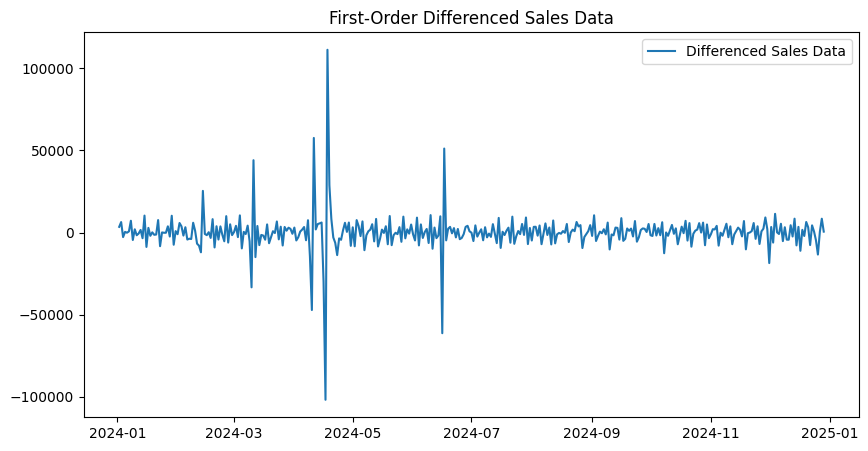

In [60]:
# Apply first-order differencing
sales_diff = sales_data_daily.diff().dropna()

# Perform ADF test again
adf_result_diff = adfuller(sales_diff)

print(f"ADF Statistic (After Differencing): {adf_result_diff[0]}")
print(f"P-Value (After Differencing): {adf_result_diff[1]}")
for key, value in adf_result_diff[4].items():
    print(f"Critical Value ({key}): {value}")

# Plot the differenced series
plt.figure(figsize=(10,5))
plt.plot(sales_diff, label="Differenced Sales Data")
plt.title("First-Order Differenced Sales Data")
plt.legend()
plt.show()


Since the ADF statistic (-18.69) is much lower than all critical values, and the p-value (≈ 0) is far below 0.05, we reject the null hypothesis. This confirms that the first-order differencing has made the data stationary.

Plotting ACF and PACF for ARIMA Model Selection

Autocorrelation Function (ACF), Partial Autocorrelation Function (PACF)

Determine p (AR order) → Check Partial Autocorrelation Function (PACF) plot.

Determine q (MA order) → Check Autocorrelation Function (ACF) plot.

Use the identified (p, d=1, q) values to train the ARIMA model.

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

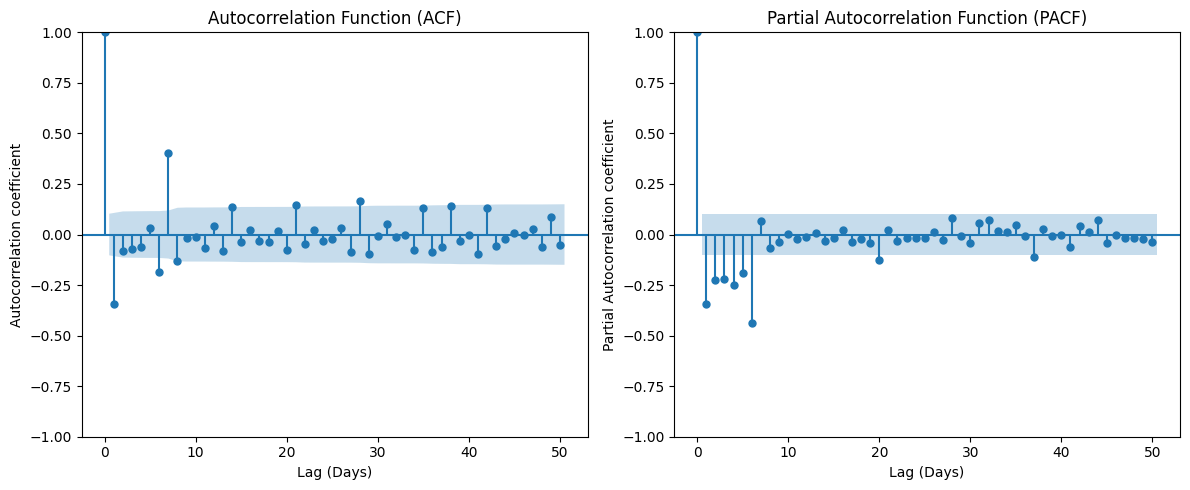

In [62]:
# Set figure size
plt.figure(figsize=(12,5))

# ACF Plot (to determine MA(q))
plt.subplot(121)
plot_acf(sales_diff, lags=50, ax=plt.gca())  # Adjust lags based on data
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag (Days)") 
plt.ylabel("Autocorrelation coefficient")

# PACF Plot (to determine AR(p))
plt.subplot(122)
plot_pacf(sales_diff, lags=50, ax=plt.gca(), method='ywm')  # Using 'ywm' to avoid warnings
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag (Days)") 
plt.ylabel("Partial Autocorrelation coefficient")

plt.tight_layout()
plt.show()


Shaded Area: 95% confidence interval (bars outside this are statistically significant).
How many points are above or below the confidence interval before the next point enters the blue area?
ACF-Q-moving average order, the number of past errors used in the model.
PACF-P-autoregressive order, the last no.of data points are used to predict the future value.
Differencing in ARIMA primarily removes trends to make the data stationary.

5,1,4

p=1,6 d=1, q=1,3 


In [63]:
# Define the ranges
p_values = [1, 2, 3, 4, 5, 6]
d_values = [1]  # Fixed at 1
q_values = [1, 2, 3, 4, 5, 6]


orders = [(p, d, q) for p in p_values for d in d_values for q in q_values]


# Dictionary to store results
results = {}

for order in orders:
    print(f"Training ARIMA{order} model...")
    
    # Fit the model
    model = ARIMA(sales_data_daily, order=order)
    model_fit = model.fit()
    
    # Get predictions
    predictions = model_fit.predict(start=len(sales_data_daily)-30, end=len(sales_data_daily)-1)  # Last 30 days
    
    # Calculate errors
    mae = mean_absolute_error(sales_data_daily[-30:], predictions)
    mse = mean_squared_error(sales_data_daily[-30:], predictions)
    rmse = np.sqrt(mse)
    
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    
        
    # Store results
    results[order] = {"MAE": mae, "MSE": mse, "RMSE": rmse}
    
    print(f"ARIMA{order} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}\n")

# Find the best model based on RMSE
best_model = min(results, key=lambda x: results[x]["RMSE"])
print(f"Best ARIMA Model: {best_model} with RMSE: {results[best_model]['RMSE']:.4f}")


Training ARIMA(1, 1, 1) model...
Mean Absolute Error (MAE): 4619.47
Mean Squared Error (MSE): 35468532.27
Root Mean Squared Error (RMSE): 5955.55
ARIMA(1, 1, 1) - MAE: 4619.4705, MSE: 35468532.2697, RMSE: 5955.5463

Training ARIMA(1, 1, 2) model...
Mean Absolute Error (MAE): 4616.67
Mean Squared Error (MSE): 35496300.46
Root Mean Squared Error (RMSE): 5957.88
ARIMA(1, 1, 2) - MAE: 4616.6732, MSE: 35496300.4629, RMSE: 5957.8772

Training ARIMA(1, 1, 3) model...
Mean Absolute Error (MAE): 4580.69
Mean Squared Error (MSE): 34578043.95
Root Mean Squared Error (RMSE): 5880.31
ARIMA(1, 1, 3) - MAE: 4580.6948, MSE: 34578043.9455, RMSE: 5880.3099

Training ARIMA(1, 1, 4) model...
Mean Absolute Error (MAE): 4476.34
Mean Squared Error (MSE): 32910120.72
Root Mean Squared Error (RMSE): 5736.73
ARIMA(1, 1, 4) - MAE: 4476.3432, MSE: 32910120.7247, RMSE: 5736.7343

Training ARIMA(1, 1, 5) model...
Mean Absolute Error (MAE): 4340.46
Mean Squared Error (MSE): 31532288.30
Root Mean Squared Error (RMSE)

c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Absolute Error (MAE): 4603.08
Mean Squared Error (MSE): 35430829.62
Root Mean Squared Error (RMSE): 5952.38
ARIMA(2, 1, 2) - MAE: 4603.0772, MSE: 35430829.6207, RMSE: 5952.3802

Training ARIMA(2, 1, 3) model...
Mean Absolute Error (MAE): 4501.44
Mean Squared Error (MSE): 32982828.58
Root Mean Squared Error (RMSE): 5743.07
ARIMA(2, 1, 3) - MAE: 4501.4449, MSE: 32982828.5809, RMSE: 5743.0679

Training ARIMA(2, 1, 4) model...
Mean Absolute Error (MAE): 4042.33
Mean Squared Error (MSE): 29430635.75
Root Mean Squared Error (RMSE): 5425.00
ARIMA(2, 1, 4) - MAE: 4042.3336, MSE: 29430635.7543, RMSE: 5425.0010

Training ARIMA(2, 1, 5) model...
Mean Absolute Error (MAE): 4091.03
Mean Squared Error (MSE): 29717757.53
Root Mean Squared Error (RMSE): 5451.40
ARIMA(2, 1, 5) - MAE: 4091.0277, MSE: 29717757.5306, RMSE: 5451.3996

Training ARIMA(2, 1, 6) model...
Mean Absolute Error (MAE): 4318.12
Mean Squared Error (MSE): 31309929.07
Root Mean Squared Error (RMSE): 5595.53
ARIMA(2, 1, 6) - MAE: 4

c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Absolute Error (MAE): 4376.44
Mean Squared Error (MSE): 30919159.52
Root Mean Squared Error (RMSE): 5560.50
ARIMA(3, 1, 2) - MAE: 4376.4368, MSE: 30919159.5228, RMSE: 5560.4999

Training ARIMA(3, 1, 3) model...
Mean Absolute Error (MAE): 4420.99
Mean Squared Error (MSE): 32830843.87
Root Mean Squared Error (RMSE): 5729.82
ARIMA(3, 1, 3) - MAE: 4420.9948, MSE: 32830843.8685, RMSE: 5729.8206

Training ARIMA(3, 1, 4) model...
Mean Absolute Error (MAE): 4361.76
Mean Squared Error (MSE): 32812493.90
Root Mean Squared Error (RMSE): 5728.22
ARIMA(3, 1, 4) - MAE: 4361.7555, MSE: 32812493.8969, RMSE: 5728.2191

Training ARIMA(3, 1, 5) model...
Mean Absolute Error (MAE): 4032.01
Mean Squared Error (MSE): 28724553.83
Root Mean Squared Error (RMSE): 5359.53
ARIMA(3, 1, 5) - MAE: 4032.0090, MSE: 28724553.8329, RMSE: 5359.5293

Training ARIMA(3, 1, 6) model...


c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 3926.44
Mean Squared Error (MSE): 27484395.81
Root Mean Squared Error (RMSE): 5242.56
ARIMA(3, 1, 6) - MAE: 3926.4370, MSE: 27484395.8066, RMSE: 5242.5562

Training ARIMA(4, 1, 1) model...
Mean Absolute Error (MAE): 4413.93
Mean Squared Error (MSE): 32754193.60
Root Mean Squared Error (RMSE): 5723.13
ARIMA(4, 1, 1) - MAE: 4413.9302, MSE: 32754193.5951, RMSE: 5723.1280

Training ARIMA(4, 1, 2) model...


c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Absolute Error (MAE): 4268.69
Mean Squared Error (MSE): 31325579.24
Root Mean Squared Error (RMSE): 5596.93
ARIMA(4, 1, 2) - MAE: 4268.6871, MSE: 31325579.2415, RMSE: 5596.9259

Training ARIMA(4, 1, 3) model...
Mean Absolute Error (MAE): 4303.31
Mean Squared Error (MSE): 30379881.99
Root Mean Squared Error (RMSE): 5511.79
ARIMA(4, 1, 3) - MAE: 4303.3131, MSE: 30379881.9878, RMSE: 5511.7948

Training ARIMA(4, 1, 4) model...


c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 3602.98
Mean Squared Error (MSE): 22401609.54
Root Mean Squared Error (RMSE): 4733.03
ARIMA(4, 1, 4) - MAE: 3602.9762, MSE: 22401609.5443, RMSE: 4733.0339

Training ARIMA(4, 1, 5) model...


c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 3702.01
Mean Squared Error (MSE): 23837938.33
Root Mean Squared Error (RMSE): 4882.41
ARIMA(4, 1, 5) - MAE: 3702.0146, MSE: 23837938.3304, RMSE: 4882.4111

Training ARIMA(4, 1, 6) model...


c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 3889.31
Mean Squared Error (MSE): 25894455.79
Root Mean Squared Error (RMSE): 5088.66
ARIMA(4, 1, 6) - MAE: 3889.3112, MSE: 25894455.7902, RMSE: 5088.6595

Training ARIMA(5, 1, 1) model...
Mean Absolute Error (MAE): 4486.93
Mean Squared Error (MSE): 33093811.87
Root Mean Squared Error (RMSE): 5752.72
ARIMA(5, 1, 1) - MAE: 4486.9298, MSE: 33093811.8692, RMSE: 5752.7221

Training ARIMA(5, 1, 2) model...


c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Mean Absolute Error (MAE): 4272.22
Mean Squared Error (MSE): 31345873.54
Root Mean Squared Error (RMSE): 5598.74
ARIMA(5, 1, 2) - MAE: 4272.2241, MSE: 31345873.5366, RMSE: 5598.7386

Training ARIMA(5, 1, 3) model...
Mean Absolute Error (MAE): 4297.30
Mean Squared Error (MSE): 30288079.51
Root Mean Squared Error (RMSE): 5503.46
ARIMA(5, 1, 3) - MAE: 4297.3009, MSE: 30288079.5113, RMSE: 5503.4607

Training ARIMA(5, 1, 4) model...


c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 3570.62
Mean Squared Error (MSE): 21905946.16
Root Mean Squared Error (RMSE): 4680.38
ARIMA(5, 1, 4) - MAE: 3570.6187, MSE: 21905946.1594, RMSE: 4680.3788

Training ARIMA(5, 1, 5) model...


c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 3819.07
Mean Squared Error (MSE): 25138891.64
Root Mean Squared Error (RMSE): 5013.87
ARIMA(5, 1, 5) - MAE: 3819.0662, MSE: 25138891.6385, RMSE: 5013.8699

Training ARIMA(5, 1, 6) model...
Mean Absolute Error (MAE): 4155.53
Mean Squared Error (MSE): 29607184.80
Root Mean Squared Error (RMSE): 5441.25
ARIMA(5, 1, 6) - MAE: 4155.5258, MSE: 29607184.7967, RMSE: 5441.2485

Training ARIMA(6, 1, 1) model...


c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Mean Absolute Error (MAE): 4112.93
Mean Squared Error (MSE): 28329498.61
Root Mean Squared Error (RMSE): 5322.55
ARIMA(6, 1, 1) - MAE: 4112.9329, MSE: 28329498.6080, RMSE: 5322.5463

Training ARIMA(6, 1, 2) model...
Mean Absolute Error (MAE): 4107.29
Mean Squared Error (MSE): 28353011.05
Root Mean Squared Error (RMSE): 5324.75
ARIMA(6, 1, 2) - MAE: 4107.2867, MSE: 28353011.0546, RMSE: 5324.7546

Training ARIMA(6, 1, 3) model...
Mean Absolute Error (MAE): 4061.33
Mean Squared Error (MSE): 27891498.29
Root Mean Squared Error (RMSE): 5281.24
ARIMA(6, 1, 3) - MAE: 4061.3262, MSE: 27891498.2902, RMSE: 5281.2402

Training ARIMA(6, 1, 4) model...
Mean Absolute Error (MAE): 4061.11
Mean Squared Error (MSE): 27889904.59
Root Mean Squared Error (RMSE): 5281.09
ARIMA(6, 1, 4) - MAE: 4061.1148, MSE: 27889904.5879, RMSE: 5281.0893

Training ARIMA(6, 1, 5) model...
Mean Absolute Error (MAE): 4061.23
Mean Squared Error (MSE): 27915016.07
Root Mean Squared Error (RMSE): 5283.47
ARIMA(6, 1, 5) - MAE: 4

c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


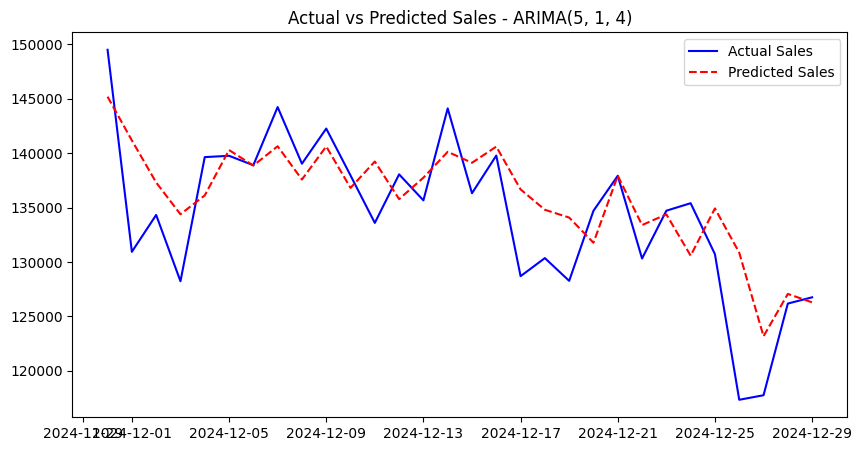

In [64]:
# Fit the best model
best_arima_model = ARIMA(sales_data_daily, order=best_model)
best_model_fit = best_arima_model.fit()

# Get predictions
forecast = best_model_fit.predict(start=len(sales_data_daily)-30, end=len(sales_data_daily)-1)

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(sales_data_daily[-30:], label="Actual Sales", color='blue')
plt.plot(forecast, label="Predicted Sales", color='red', linestyle='dashed')
plt.title(f"Actual vs Predicted Sales - ARIMA{best_model}")
plt.legend()
plt.show()


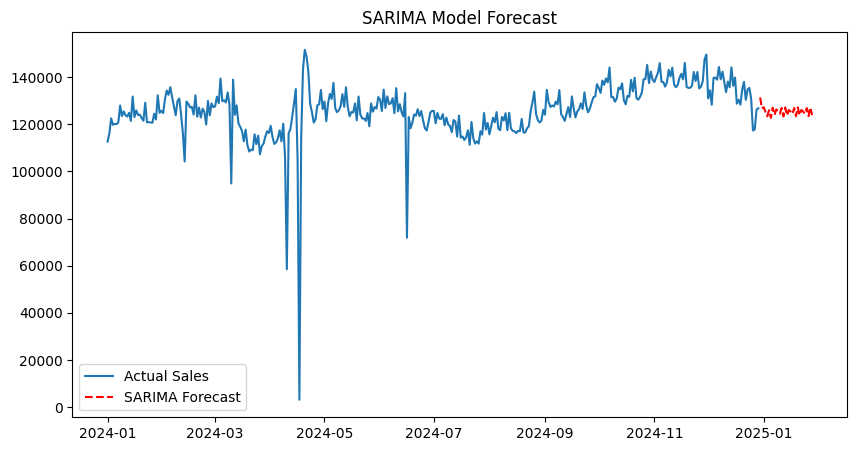

In [66]:
# Forecast the next 30 days
forecast = best_model_fit.forecast(steps=30)

# Plot the forecast
plt.figure(figsize=(10,5))
plt.plot(sales_data_daily, label="Actual Sales")
plt.plot(forecast, label="SARIMA Forecast", linestyle='dashed', color='red')
plt.title("SARIMA Model Forecast")
plt.legend()
plt.show()
